In [3]:
import os
import torch
import numpy as np

# CODE FILES HERE
from model_params import get_model_data_tdcvae
from models.tdcvae.tdcvae import TD_Cvae, Encoder, Decoder
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution,\
plot_transformed_images, plot_y_space_thetas, plot_y_space_scales
from auxiliary import get_latent_spaces, produce_alphas_radiuses
from preprocessing import RandomPreprocessing#, preprocess_batch_rand

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [ ]:
# only mnist available
dataset_arg = "mnist"
data = get_model_data_tdcvae(dataset_arg)

In [ ]:
directories = Directories("tdcvae", dataset_arg.lower(), data["z_dim"], make_dirs=False)
data_loader = DataLoader(directories, data["batch_size"], dataset_arg.lower(), thetas=data["thetas"], scales=data["scales"])
model = TD_Cvae(data_loader.input_dim, data_loader.input_dim, data["z_dim"], data["beta"], rotations=True)
solver = Solver(model, data_loader, data["optimizer"], data["epochs"], data["optim_config"], step_config=data["step_config"],\
                lr_scheduler=data["lr_scheduler"], tdcvae_mode=True, save_model_state=False)
solver.main()

In [ ]:
# Uncomment to load a model to continue training.
#solver = torch.load("../results/tdcvae/MNIST_z=2_0/model_state.pt")
#solver.main()

In [34]:
# Uncomment to load a trained model for inference.
solver = torch.load("../../results_slurm/test_thing2/mnist_z=2_0/model_state.pt", map_location='cpu')
solver.model.eval()
solver.data_loader.directories.make_dirs = "../../results_slurm/test_thing2/mnist_z=2_0/"
solver.data_loader.directories.result_dir = "../../results_slurm/test_thing2/"
#solver.data_loader.scale_range_1 = data["scales"]["scale_1"]
#solver.data_loader.scale_range_2 = data["scales"]["scale_2"]
#solver.data_loader.theta_range_1 = data["thetas"]["theta_1"]
#solver.data_loader.theta_range_2 = data["thetas"]["theta_2"]
print(solver.data_loader.thetas, solver.data_loader.scales)
print(solver.data_loader.scale_range_1, solver.data_loader.scale_range_2)
print(solver.data_loader.theta_range_1, solver.data_loader.theta_range_2)
model = TD_Cvae(784, 784, 2, solver.model.beta, rotations=True)
model.encoder.load_state_dict(solver.model.encoder.state_dict())
model.decoder.load_state_dict(solver.model.decoder.state_dict())

{'theta_1': [-3.141592653589793, 3.141592653589793], 'theta_2': [-0.7853981633974483, 0.7853981633974483]} {'scale_1': [0.85, 1.15], 'scale_2': [-0.15, 0.15]}
[0.85, 1.15] [-0.15, 0.15]
[-3.141592653589793, 3.141592653589793] [-0.7853981633974483, 0.7853981633974483]


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 1
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

In [6]:
# make random transformations
if solver.data_loader.thetas and solver.data_loader.scales:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2,\
                                    solver.data_loader.scale_range_1, solver.data_loader.scale_range_2)
elif solver.data_loader.thetas:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2)
elif solver.data_loader.scales:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    scale_range_1=solver.data_loader.scale_range_1, scale_range_2=solver.data_loader.scale_range_2)
test_loader = solver.data_loader.get_new_test_data_loader()
mode = "tdcvae"
z_space, y_space, _ = get_latent_spaces(solver.model, mode, test_loader, solver.data_loader.num_test_samples,\
                                        solver.model.z_dim, solver.data_loader.batch_size, solver.data_loader.with_labels,\
                                        solver.data_loader.input_dim, rand_transformation)

In [ ]:
# visualize q(z) (latent space z)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    print("\mu(z_0)={}, \sigma(z_0)={}".format(np.mean(z_space[:, 0]), np.std(z_space[:, 0])))
    print("\mu(z_1)={}, \sigma(z_1)={}".format(np.mean(z_space[:, 1]), np.std(z_space[:, 1])))
    if solver.data_loader.thetas:
        ticks = np.arange(np.degrees(solver.data_loader.theta_range_2[0]), np.degrees(solver.data_loader.theta_range_2[1])+1, 10).tolist()
        labels = np.degrees(rand_transformation.prepro_params["theta_diff"]).tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="theta", labels=labels, colors=len(ticks)-1)
    if solver.data_loader.scales:
        ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_2[0]*10),\
                                                       int((solver.data_loader.scale_range_2[1]+0.1)*10))]
        ticks = np.linspace(solver.data_loader.scale_range_2[0], solver.data_loader.scale_range_2[1], 4)
        labels = rand_transformation.prepro_params["scale_diff"].tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="scale", labels=labels, colors=len(ticks)-1)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

In [ ]:
# Visualize q(y)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    print("\mu(y_0)={}, \sigma(y_0)={}".format(np.mean(y_space[:, 0]), np.std(y_space[:, 0])))
    print("\mu(y_1)={}, \sigma(y_1)={}".format(np.mean(y_space[:, 1]), np.std(y_space[:, 1])))
    if solver.data_loader.thetas:
        ticks = np.arange(np.degrees(solver.data_loader.theta_range_1[0]), np.degrees(solver.data_loader.theta_range_1[1])+1, 30).tolist()
        labels = np.degrees(rand_transformation.prepro_params["theta_1"]).tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="theta", labels=labels)
    if solver.data_loader.scales:
        ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
        labels = rand_transformation.prepro_params["scale_1"].tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="scale", labels=labels)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

True True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


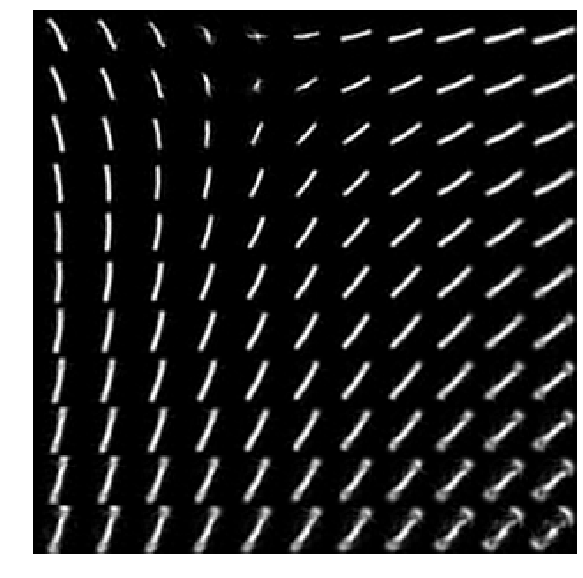

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


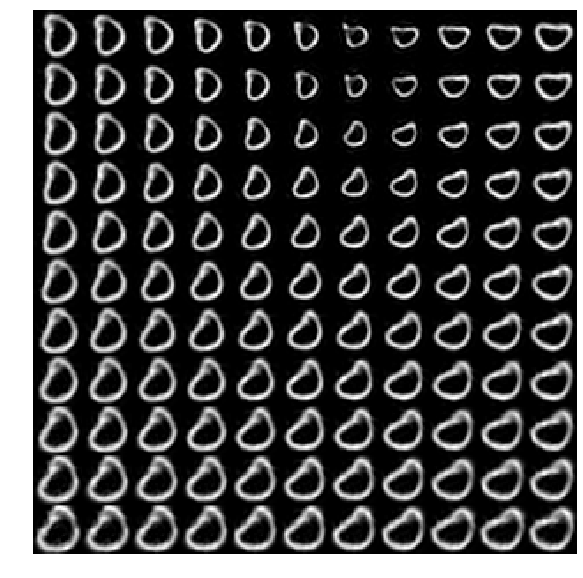

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


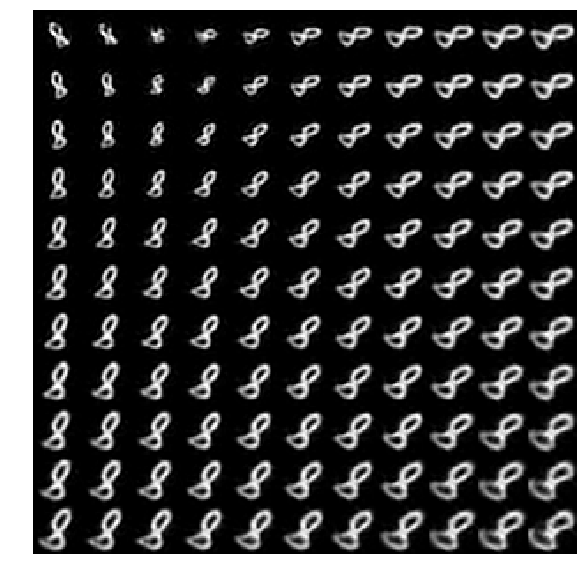

In [36]:
# Visualizations of learned q(z) for generative models with two-dimensional latent space
if solver.model.z_dim == 2:
    n = 11
    if solver.data_loader.thetas and solver.data_loader.scales:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)
    elif solver.data_loader.thetas:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)
    elif solver.data_loader.scales:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)
    test_loader = solver.data_loader.get_new_test_data_loader()
    x_t, labels = iter(test_loader).next()  
    x_t, _ = rand_transformation.preprocess_samples(x_t, save=False)
    for i in range(3):
        plot_latent_manifold(model.decoder, solver, "bone", grid_x, grid_y, n=n, x_t=x_t[i].view(1, 784), label=labels[i])
else:
    print("Plot is not possible as dimension of z is not 2 or model is loaded")

In [ ]:
# show how the transformation actually produces results in practice.
test_loader = solver.data_loader.get_new_test_data_loader()
file_name = solver.data_loader.directories.result_dir + "/plot_transformed_images_"\
            + solver.data_loader.dataset + ".png"
plot_transformed_images(test_loader, solver.data_loader.batch_size, save_plot=solver.data_loader.directories.make_dirs, file_name=file_name)

In [ ]:
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    test_loader = solver.data_loader.get_new_test_data_loader()
    num_rotations = 30
    num_scales = 30
    num_samples = 20
    test_loader = solver.data_loader.get_new_test_data_loader()
    x_t, targets = iter(test_loader).next()
    x_t = x_t.view(-1, 784).numpy()
    thetas = np.linspace(0, 1, num_rotations) * 2 * np.pi
    scales = 0.7 + np.linspace(0, 1, num_scales) * 0.6
    ys = produce_alphas_radiuses(model.encoder, x_t, scales, thetas, num_samples, num_scales, num_rotations)
    print("Labels of data", targets[:num_samples])

In [ ]:
# scatter plot of the ys with thetas
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    ticks = np.arange(np.degrees(thetas[0]), np.degrees(thetas[-1])+1, 30).tolist()
    labels = np.degrees(thetas)
    print("Thetas applied: {}".format(labels))
    file_name = solver.data_loader.directories.result_dir + "/plot_y_space_thetas_fixed_"\
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_y_space_thetas(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

In [ ]:
# scatter plot of the ys with scales
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    labels = scales
    ticks = np.linspace(scales[0], scales[-1], 13).tolist()
    ticks = np.around(ticks, decimals=2)
    print("Scales: {}".format(labels))
    file_name = solver.data_loader.directories.result_dir + "/plot_y_space_scales_fixed_"\
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_y_space_scales(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

In [ ]:
# for rotation
if solver.model.z_dim == 2 and solver.data_loader.thetas:
    file_name = solver.data_loader.directories.result_dir + "/plot_prepro_alpha_params_distribution_" \
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_prepro_alpha_params_distribution(ys, thetas, \
                                          solver.data_loader.directories.make_dirs, file_name,\
                                          solver.data_loader.dataset)

In [ ]:
# for scaling
if solver.model.z_dim == 2 and solver.data_loader.scales:
    file_name = solver.data_loader.directories.result_dir + "/plot_prepro_radius_params_distribution_" \
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_prepro_radius_params_distribution(ys, scales,\
                                          solver.data_loader.directories.make_dirs, file_name,\
                                          solver.data_loader.dataset)

In [ ]:
#torch.save(ys, solver.data_loader.directories.result_dir + "/ys.pt")
#ys = torch.load(solver.data_loader.directories.result_dir + "/ys.pt")
from plots import test
test(ys)
import matplotlib.pyplot as plt
#plt.scatter(rs, alphas)